# Data Understanding - Server Logs
### 1. Nguồn dữ liệu
### 2. Mô tả trường thông tin
#### Dữ liệu log có cấu trúc gồm các trường chính:
| **Tên Trường**        | **Kiểu Dữ Liệu**       | **Mô Tả Ý Nghĩa**                                                      |
|-----------------------|------------------------|-------------------------------------------------------------------------|
| `std`                 | String                 | Loại log: `stdout` (log bình thường) hoặc `stderr` (log lỗi).                |
| `remote_address`      | String                 | Địa chỉ IP của máy khách.                                      |
| `remote_user`         | String                 | Tên người dùng (dấu `-` nếu không có thông tin).     |
| `datetime`            | Datetime               | Thời gian và ngày giờ của request, định dạng theo chuẩn ISO8601: `yyyy-MM-dd'T'HH:mm:ss.SSSSSSSSS+hh:mm`|
| `method`              | String                 | Phương thức HTTP (ví dụ: GET, POST, PUT, DELETE,...)                 |
| `path`                | String                 | Đường dẫnđược truy cập trên máy chủ (ví dụ: `/status`, `/api/data`)           |
| `header`              | String                 | Phiên bản giao thức HTTP (ví dụ: `HTTP/1.1`).                           |
| `status`              | Integer                | Mã trạng thái HTTP trả về (ví dụ: `200`, `404`, `500`)                |
| `bytes_sent`          | Integer                | Số byte dữ liệu đã được gửi trong phản hồi (response)                |
| `referer`             | String                 | URL nguồn (referer) của request           |
| `user_agent`          | String                 | Thông tin về trình duyệt hoặc công cụ gửi request. |
### 3. Tách các dòng log thành các trường dữ liệu
#### Ví dụ ta có dữ liệu như sau:<br>2024-11-30T13:51:41.272335253+07:00 stdout F 127.0.0.1 - - [30/Nov/2024:06:51:41 +0000] "GET /status HTTP/1.1" 200 1164 "-" "kong-ingress-controller/3.3.1"<br>2024-11-30T13:51:42.210291667+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status HTTP/1.1" 200 1165 "-" "kube-probe/1.27"<br>2024-11-30T13:51:42.213094133+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status/ready HTTP/1.1" 200 19 "-" "kube-probe/1.27"

#### Mục tiêu là tách các trường dữ liệu và đưa về dạng:<br>
| std    | remote_address | remote_user | datetime                    | method | path          | header   | status | bytes_sent | referer | user_agent                     |
|--------|----------------|-------------|-----------------------------|--------|---------------|----------|--------|------------|---------|--------------------------------|
| stdout | 127.0.0.1      | -           | 30/Nov/2024:06:51:41 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1164       | -       | kong-ingress-controller/3.3.1 |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1165       | -       | kube-probe/1.27               |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status/ready | HTTP/1.1 | 200    | 19         | -       | kube-probe/1.27               |
#### Để đạt được các trường dữ liệu đó, ta cần thiết kế biểu thức regex tương ứng: <br> 
```regex
^
\S+                              # Phần đầu dòng, bỏ qua chuỗi không chứa khoảng trắng.
 (?P<std>\S+)                    # Nhóm `std`: stdout/stderr.
 \S+                             # Bỏ qua một chuỗi không chứa khoảng trắng.
 (?P<remote_address>\d+\.\d+\.\d+\.\d+) # Nhóm `remote_address`: Địa chỉ IP (IPv4).
 -                               # Ký tự gạch ngang.
 (?P<remote_user>[^ ]*)          # Nhóm `remote_user`: Tên người dùng (hoặc trống: `-`).
 \[(?P<datetime>[^\]]+)\]        # Nhóm `datetime`: Thời gian (nằm trong dấu `[]`).
 "(?P<method>\w+)                # Nhóm `method`: Phương thức HTTP (GET, POST,...).
  (?P<path>[^\s]+)               # Nhóm `path`: Đường dẫn truy cập.
  (?P<header>[^\"]+)"            # Nhóm `header`: Phiên bản giao thức (HTTP/1.1).
 (?P<status>\d+)                 # Nhóm `status`: Mã trạng thái HTTP (200, 404,...).
 (?P<bytes_sent>\d+)             # Nhóm `bytes_sent`: Số byte đã gửi.
 "(?P<referer>[^\"]*)"           # Nhóm `referer`: URL nguồn (có thể trống: `-`).
 "(?P<user_agent>[^\"]*)"        # Nhóm `user_agent`: Thông tin User-Agent.

In [12]:
import sys
import os
module_path = r"D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding"
if module_path not in sys.path:
    sys.path.append(module_path)
from logtransform import LogTransform

In [13]:
source_path = r"D:\CODING\Project\Server Log Analysis\data\raw\server_log.txt"
destination_path = r"D:\CODING\Project\Server Log Analysis\data\interim\parsed_logs.csv"
log_pattern= r'^\S+ (?P<std>\S+) \S+ (?P<remote_address>\d+\.\d+\.\d+\.\d+) - (?P<remote_user>[^ ]*) \[(?P<datetime>[^\]]+)\] "(?P<method>\w+) (?P<path>[^\s]+) (?P<header>[^\"]+)" (?P<status>\d+) (?P<bytes_sent>\d+) "(?P<referer>[^\"]*)" "(?P<user_agent>[^\"]*)"'

In [14]:
logtransform = LogTransform(source_path)
df = logtransform.read_log_file(log_pattern)
df = logtransform.transform(df)

df.to_csv(destination_path)

D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding\logtransform.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['std'] = df['std'].replace({'stdout': 0, 'stderr': 1})
D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding\logtransform.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['method'] = df['method'].replace({'GET': 0, 'POST': 1})


In [15]:
df.head()

,std,remote_address,datetime,method,path,status,bytes_sent,referer,user_agent,day,hour,month
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status,200,1165,-,kube-probe/1.27,30,6,11
2,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status/ready,200,19,-,kube-probe/1.27,30,6,11
3,0,127.0.0.1,2024-11-30 06:51:44+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11
4,0,127.0.0.1,2024-11-30 06:51:47+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11


### 4. Minh họa dữ liệu

In [16]:
import sys
import os
module_path = r"D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding"
if module_path not in sys.path:
    sys.path.append(module_path)
from visualize import Visualize

In [17]:

log_path = r"D:\CODING\Project\Server Log Analysis\data\interim\parsed_logs.csv"
visualizer = Visualize(log_path)

#### Số lượng lỗi qua thời gian

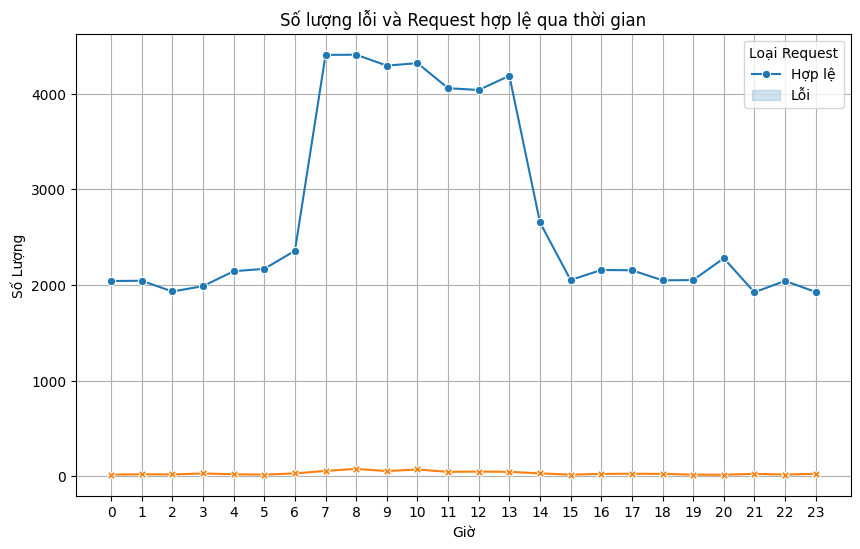

In [18]:

visualizer.plot_errors_over_time()

#### Phân bố các loại request

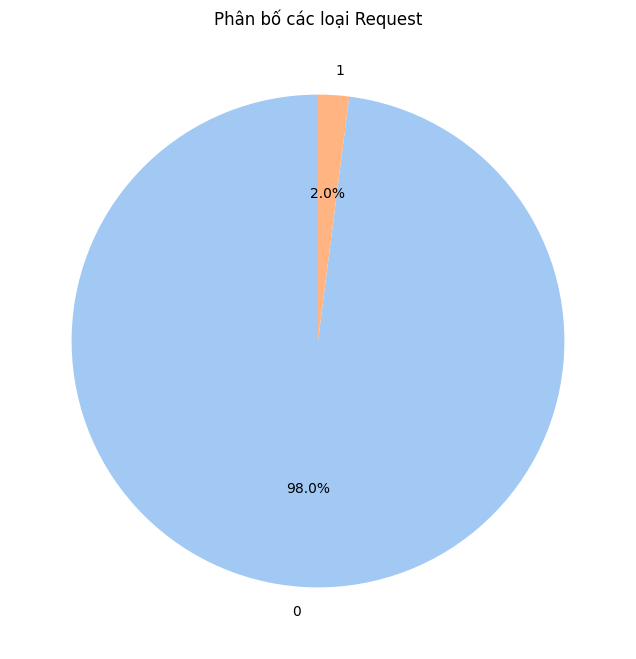

In [19]:
visualizer.plot_request_distribution()

#### Lượng dữ liệu gửi đi mỗi giờ

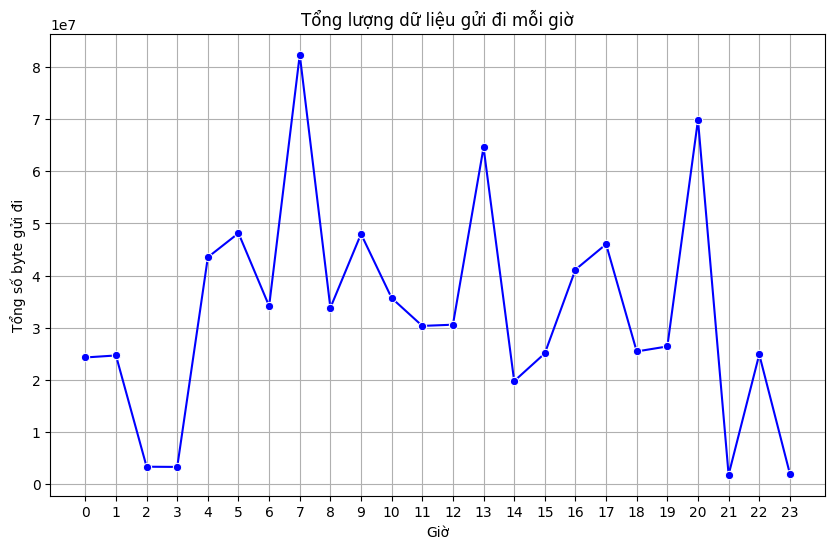

In [20]:
visualizer.plot_bytes_sent_per_hour()

#### Phân loại log level và thống kê cho từng loại

Số lượng log từng loại:
  INFO: 65657
  ERROR: 656
  CRITICAL: 98


D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding\visualize.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=log_level_counts.index, y=log_level_counts.values, palette="viridis")


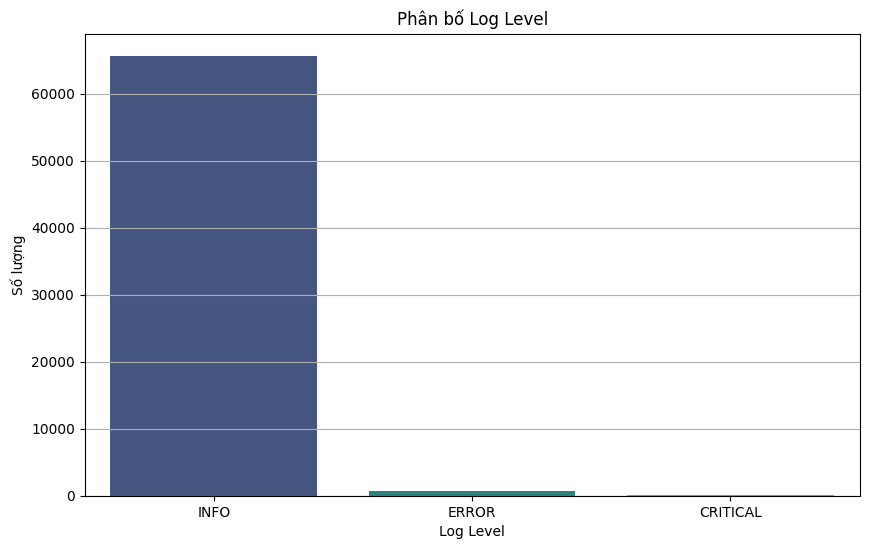

In [21]:
visualizer.plot_log_level()